# Building a CNN Model for Alzheimer's Diagnosis Using MRI

In this project, we will walk through the process of training a CNN classifier to predict whether an MRI scan of a patient shows signs of Alzheimer's disease or not. We will be using transfer learning, specifically the ResNet50 pre-trained model as our base model, and adding custom layers on top to fine-tune the model for our specific task.

To get started, you will need to access the Alzheimer's dataset from the Kaggle website (https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images), which contains MRI scans of patients with Alzheimer's disease as well as healthy patients. You can download the dataset as a zip file and extract the image data within the subfolders. Creating an account on Kaggle is necessary to access the dataset.

Once you have the dataset, you can start training your binary classification model using the CNN architecture. The goal is to accurately identify patients with Alzheimer's disease using MRI scans. We will be evaluating the performance of our model using accuracy, precision, recall, and F1-score.

The significance of building an accurate Alzheimer's disease classifier cannot be overstated. Early diagnosis and treatment of the disease can have a profound impact on the quality of life of patients and their families. By completing this project, you will gain experience in using transfer learning for image classification and contribute to the development of tools for early detection and treatment of Alzheimer's disease.

## Data Preparation

### Setting up Directories and Classes

The original classification of the dataset includes four classes (Mild Demented, Moderate Demented, Non Demented, and Very Mild Demented). However, for the purpose of this project, the classification has been **binarized** into two classes: NonDemented and Mild/Moderate Demented. The 'NonDemented' class is assigned the label 0, while the 'MildDemented' and 'ModerateDemented' classes are assigned the label 1.

In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import os
import glob
import cv2
import random

# Set working directory
os.chdir('/Users/Farzad/Desktop/AlzheimersCNN/')

# Define directories for train and test data
train_dir = 'Dataset/train/'
test_dir = 'Dataset/test/'

# Define classes
classes = {'NonDemented': 0, 'MildDemented': 1, 'ModerateDemented': 1}

### Data Augmentation (for Minor Label)

Data augmentation is a technique used to **increase the size** of a dataset by creating new examples through transformations of existing data. This technique is commonly used in deep learning to **prevent overfitting** and improve the **generalization performance** of a model.

In this code, we use the `Augmentor` library to perform data augmentation on MRI images of `MildDemented` and `ModerateDemented` patients. The augmentation includes **flipping**, **cropping**, and **shearing** the images to generate new samples.

The `augment_data` function takes the path to the data folder and the number of samples to generate as input, and performs the desired augmentations using the `Pipeline` object from `Augmentor`. We apply this function to both classes of data to **increase the size of our dataset**.

In [2]:
import Augmentor # !pip install Augmentor

# Define a function to perform data augmentation for a given path to data
def augment_data(path_to_data, num_of_samples):
    
    output_dir = os.path.join(path_to_data, 'output')
    
    # Check if the output directory already exists
    if os.path.isdir(output_dir):
        print(f"Skipping augmentation for {path_to_data}: output directory already exists.")
        return
    
    # Create an Augmentor pipeline for the given data path
    p = Augmentor.Pipeline(path_to_data, save_format='jpg')
    
    # Add the desired augmentations to the pipeline
    p.flip_left_right(probability=0.5)
    p.crop_centre(probability=0.5, percentage_area=0.9)
    p.shear(probability=0.5, max_shear_left=10, max_shear_right=10)
    
    # Generate the desired number of augmented samples
    p.sample(num_of_samples)

# Define the paths to the MildDemented and ModerateDemented data folders
path_to_mild = 'Dataset/train/MildDemented/'
path_to_moderate = 'Dataset/train/ModerateDemented/'

# Define the number of samples to generate for each class
num_of_mild_samples = 1670
num_of_moderate_samples = 121

# Perform data augmentation for the MildDemented class
augment_data(path_to_mild, num_of_mild_samples)

# Perform data augmentation for the ModerateDemented class
augment_data(path_to_moderate, num_of_moderate_samples)

Processing <PIL.Image.Image image mode=L size=158x188 at 0x7FB2E11F5970>:   1%|          | 14/1670 [00:00<00:19, 84.39 Samples/s]                  

Initialised with 717 image(s) found.
Output directory set to Dataset/train/MildDemented/output.

Processing <PIL.Image.Image image mode=L size=158x188 at 0x7FB2E12F7F70>: 100%|██████████| 1670/1670 [00:03<00:00, 497.18 Samples/s]                  
Processing <PIL.Image.Image image mode=L size=158x188 at 0x7FB2E1249760>:  40%|████      | 49/121 [00:00<00:00, 140.17 Samples/s]                  

Initialised with 52 image(s) found.
Output directory set to Dataset/train/ModerateDemented/output.

Processing <PIL.Image.Image image mode=L size=158x188 at 0x7FB2E11A5460>: 100%|██████████| 121/121 [00:00<00:00, 427.65 Samples/s]                  


### Getting Image Paths and Labels

In this step, we define a function called `get_paths_labels` to get image paths and labels from a directory. This function takes a directory path and a dictionary of classes as input, and returns two lists: `image_paths` and `labels`.

Using this function, we create pandas dataframes for the training and validation datasets. These dataframes contain the image paths and corresponding labels for each dataset.

We also check the number of images in each dataset and save the dataframes as CSV files. Finally, we print the first five rows of the training and validation dataframes.

In [3]:
# Define a function to get image paths and labels from a directory
def get_paths_labels(directory, classes):
    # Define empty lists to store image paths and labels
    image_paths = []
    labels = []
    for class_name in classes.keys():
        class_path = os.path.join(directory, class_name, '*.jpg')
        for image_path in glob.glob(class_path):
            image_paths.append(image_path)
            labels.append(classes[class_name])
            
        # Include the image paths in the output folder generated by Augmentor
        output_path = os.path.join(directory, class_name, 'output')
        if os.path.isdir(output_path):
            output_path = os.path.join(output_path, '*.jpg')
            for image_path in glob.glob(output_path):
                image_paths.append(image_path)
                labels.append(classes[class_name])
                
    return image_paths, labels

# Get training data paths and labels
train_image_paths, train_labels = get_paths_labels(train_dir, classes)

# Get validation data paths and labels
val_image_paths, val_labels = get_paths_labels(test_dir, classes)

# Check the number of images in each dataset
print(f'Training dataset: {len(train_image_paths)} images ({len(train_labels)} labels)')
print(f'Validation dataset: {len(val_image_paths)} images ({len(val_labels)} labels)')

# Create a pandas dataframe for training and validation datasets
training_df = pd.DataFrame({'image_path':train_image_paths, 'labels':train_labels})
validation_df = pd.DataFrame({'image_path':val_image_paths, 'labels':val_labels})

# Save the dataframes as CSV files
training_df.to_csv('alzheimers-training-set.csv', index=False)
validation_df.to_csv('alzheimers-validation-set.csv', index=False)

# Print the first five rows of the training and validation dataframes
print('Training dataframe:')
print(training_df.head())
print('Validation dataframe:')
print(validation_df.head())

Training dataset: 5120 images (5120 labels)
Validation dataset: 831 images (831 labels)
Training dataframe:
                                 image_path  labels
0  Dataset/train/NonDemented/nonDem1498.jpg       0
1  Dataset/train/NonDemented/nonDem2191.jpg       0
2  Dataset/train/NonDemented/nonDem2185.jpg       0
3   Dataset/train/NonDemented/nonDem499.jpg       0
4  Dataset/train/NonDemented/nonDem2152.jpg       0
Validation dataframe:
                             image_path  labels
0  Dataset/test/NonDemented/26 (81).jpg       0
1  Dataset/test/NonDemented/27 (81).jpg       0
2  Dataset/test/NonDemented/28 (56).jpg       0
3  Dataset/test/NonDemented/29 (56).jpg       0
4  Dataset/test/NonDemented/32 (50).jpg       0


## Plotting Sample MRIs from Training Dataset

Let's display a figure with sample MRI images, from each of the "NonDemented" and "Demented" classes. This part uses OpenCV and Matplotlib libraries to read the image files, convert them to RGB format, plot them on a subplot, and add a suptitle to the figure. 

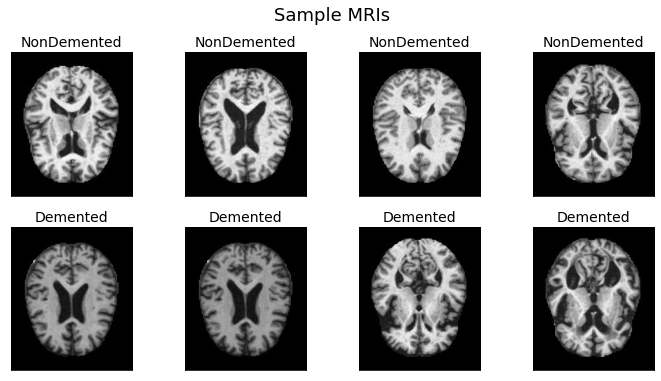

In [4]:
# Define the labels
labels = ['NonDemented', 'Demented']

# Create a figure with two rows and four columns
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(10,5))

# Loop through each label
for i in range(2):
    
    # Get the first 4 image paths for this label
    image_paths = training_df[training_df['labels'] == i]['image_path'].tolist()[:4]
    
    # Loop through each image path
    for j, path in enumerate(image_paths):
        
        # Read the image from the path
        img = cv2.imread(path)
        
        # Convert the image to RGB format
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Plot the image on the corresponding subplot
        ax[i,j].imshow(img)
        
        # Set the title of the subplot to the label of the image
        ax[i,j].set_title(labels[i], fontsize=14)
        
        # Remove the axis ticks
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        
# Add a suptitle to the figure
fig.suptitle('Sample MRIs', fontsize=18, y=1.05)

# Adjust the spacing between subplots
plt.tight_layout()

# Save the plot
fig.savefig('Figures/sample_MRIs.png', dpi=300)

# Show the plot in the Jupyter notebook
plt.show()

## TensorFlow (TF) Dataset Creation

Here, we define a batch size for the data, and two TensorFlow functions. The first function, `load_image`, reads an image from disk, decodes it, resizes it, and scales the pixel intensities to the range [0,1]. It also one-hot encodes the label. The second function, `augmentation`, performs data augmentation on the image by randomly flipping it horizontally and vertically, and then crops and resizes the image to the desired size.

We then create three TensorFlow datasets: one for training, one for validation, and one for GradCAM. The training dataset is created by taking the image paths and labels from the training data and creating a dataset with them. We shuffle the dataset, then map the `load_image` and `augmentation` functions to it, batch the data, and prefetch it for better performance. The validation dataset is created similarly, using the validation image paths and labels.

Finally, we create a dataset for GradCAM by selecting the last 10 images from the validation dataset and extracting their image paths and labels. We then read in the images, resize and scale them, and store them in a NumPy array. We one-hot encode the labels, and print out the number of images and their labels for verification (note: first, install the `tf_explain` package using pip).

In [5]:
import tensorflow as tf
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Set the batch size for training
BATCH_SIZE = 32

# Define a function to load an image from disk and preprocess it for training
@tf.function
def load_image(image_path, label):
    # Read the image from disk, decode it, resize it, and scale the
    # pixel intensities to the range [0, 1]
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.cast(image, dtype=tf.float32)
    image = image / 255.0
    
    # One-hot encode the label
    label = tf.one_hot(label, 2)

    return (image, label)

# Define a function for data augmentation
@tf.function
def augmentation(image, label):
    # Perform random horizontal and vertical flips
    image = tf.image.central_crop(image, central_fraction=0.85)
    image = tf.image.resize(image, size=(224,224))
    
    # Return the augmented image and its label
    return (image, label)

In [6]:
# Create a TensorFlow dataset for training
dataset = tf.data.Dataset.from_tensor_slices((training_df['image_path'], training_df['labels']))
dataset = (dataset.shuffle(len(training_df))
                  .map(load_image).map(augmentation)
                  .batch(BATCH_SIZE)
                  .prefetch(tf.data.AUTOTUNE)
          )

# Create a TensorFlow dataset for validation
valid_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_labels))
valid_dataset = (valid_dataset.map(load_image).map(augmentation)
                              .batch(BATCH_SIZE)
          )

In [121]:
# Create a TensorFlow dataset for explainers (Approach 1: During training)
explainer_df = validation_df[-10:]
print("Explainer dataframe:")
print(explainer_df)

explainer_image_paths = explainer_df['image_path'].to_list()
explainer_label_1 = explainer_df['labels'].to_list()

explainer_imgs = []
for img_path in explainer_image_paths:
    image = tf.io.read_file(img_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.cast(image, dtype=tf.float32)
    image = tf.image.resize(image, size=(224,224))
    image = image / 255.0
    explainer_imgs.append(image.numpy())
explainer_imgs = np.array(explainer_imgs)
explainer_label_1 = tf.one_hot(np.array(explainer_label_1), 2)

print("Number of explainer images:", len(explainer_imgs))
print("Explainer labels:")
print(explainer_label_1)

Explainer dataframe:
                                   image_path  labels
821  Dataset/test/ModerateDemented/29 (2).jpg       1
822      Dataset/test/ModerateDemented/29.jpg       1
823  Dataset/test/ModerateDemented/30 (2).jpg       1
824  Dataset/test/ModerateDemented/31 (2).jpg       1
825  Dataset/test/ModerateDemented/28 (2).jpg       1
826      Dataset/test/ModerateDemented/27.jpg       1
827      Dataset/test/ModerateDemented/32.jpg       1
828      Dataset/test/ModerateDemented/30.jpg       1
829      Dataset/test/ModerateDemented/31.jpg       1
830  Dataset/test/ModerateDemented/27 (2).jpg       1
Number of explainer images: 10
Explainer labels:
tf.Tensor(
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]], shape=(10, 2), dtype=float32)


In [8]:
# Calculate class weights
# These weights will be used to balance the contribution of each class during training
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.

class_counts = np.bincount(train_labels)
total_samples = np.sum(class_counts)
class_weight = {}
for class_idx, count in enumerate(class_counts):
    class_weight[class_idx] = (1 / count) * (total_samples / 2.0)

print('Class weights:', class_weight)

Class weights: {0: 1.0, 1: 1.0}


## Building Model using Transfer Learning

In this section of our project, we will build a model using transfer learning. Specifically, we will use the ResNet50 pre-trained model from the Keras applications module as our base model. We will add custom layers on top of the base model, freeze the base model layers, and then compile the model.

The custom layers consist of a flatten layer and two fully connected dense layers with ReLU and softmax activation functions, respectively. The output layer will have two neurons to predict our two classes.

We then compile the model with the categorical cross-entropy loss function and the Adam optimizer. Lastly, we print a summary of our model architecture.

In [9]:
# Building Model using Transfer Learning

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

# Define the base model
base_model = ResNet50(input_shape=(224, 224, 1),
                      include_top=False,
                      weights=None,
                      pooling='avg')

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

# Concatenate the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()

#tf.keras.utils.plot_model(model, to_file='mobilenetV2-Pneumonia.png', show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  3200        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

## Callback Configurations

Here we add callback functions using `EarlyStopping` and `tf-explain` libraries to be executed during the training of our model. In this code, we add an EarlyStopping callback to stop training if the validation loss doesn't improve for 5 epochs. We also ask the user which XAI (eXplainable AI) techniques they want to add as callbacks, such as **Activations**, **Occlusion**, **GradCAM**, **SmoothGrad**, and **IntegratedGradients**.

**Note**: After training the model, you can use TensorBoard to view the events in your event file by running the following command in your terminal:
tensorboard --logdir=(path-to-directory-containing-event-file)
e.g., tensorboard --logdir=/Users/Farzad/Desktop/AlzheimersCNN/tf_explain/activations/20230222-125533.569072/

Then, you can open TensorBoard in your web browser by going to generated local host, e.g., http://localhost:6006/. From there, you can explore the different tabs and visualizations to gain insights into your model's performance.

In [10]:
from tensorflow.keras.callbacks import EarlyStopping
from tf_explain.callbacks.activations_visualization import ActivationsVisualizationCallback
from tf_explain.callbacks.occlusion_sensitivity import OcclusionSensitivityCallback
from tf_explain.callbacks.grad_cam import GradCAMCallback
from tf_explain.callbacks.smoothgrad import SmoothGradCallback
from tf_explain.callbacks.integrated_gradients import IntegratedGradientsCallback


callbacks = [
    # Add EarlyStopping callback: Stop training if validation loss doesn't improve for 5 epochs
    EarlyStopping(patience=5, restore_best_weights=True)
]

# Ask the user which XAI techniques they want to add as callbacks
# Options: 'activations', 'occlusion', 'gradcam', 'smoothgrad', 'integrated_gradients'
# Note: Occlusion is a time-consuming technique.
xai_techniques = ['activations', 'gradcam', 'smoothgrad', 'integrated_gradients']

# Add ActivationsVisualizationCallback if requested
if 'activations' in xai_techniques:
    callbacks.append(
        ActivationsVisualizationCallback(
            validation_data=(explainer_imgs, explainer_label_1),
            layers_name="conv5_block3_3_conv",
            output_dir='./tf_explain/activations',
        )
    )

# Add OcclusionSensitivityCallback if requested
if 'occlusion' in xai_techniques:
    callbacks.append(
        OcclusionSensitivityCallback(
            validation_data=(explainer_imgs, explainer_label_1),
            class_index=1,
            patch_size=4, # size of the occlusion patch
            output_dir='./tf_explain/occlusion',
        )
    )

# Add GradCAMCallback if requested
if 'gradcam' in xai_techniques:
    callbacks.append(
        GradCAMCallback(
            validation_data=(explainer_imgs, explainer_label_1),
            #layer_name="conv5_block3_3_conv",
            class_index=1,
            output_dir='./tf_explain/gradcam',
        )
    )

# Add SmoothGradCallback if requested
if 'smoothgrad' in xai_techniques:
    callbacks.append(
        SmoothGradCallback(
            validation_data=(explainer_imgs, explainer_label_1),
            class_index=1,
            num_samples=20,
            noise=1.0, # variance of added noise
            output_dir='./tf_explain/smoothgrad',
        )
    )

# Add IntegratedGradientsCallback if requested
if 'integrated_gradients' in xai_techniques:
    callbacks.append(
        IntegratedGradientsCallback(
            validation_data=(explainer_imgs, explainer_label_1),
            class_index=1,
            n_steps=20, # number of steps for integrating gradients
            output_dir='./tf_explain/integrated_gradients',
        )
    )


## Training the Model

This line of code trains the model using the given training dataset for 20 epochs, and validates it using the validation dataset. It also applies class weighting and a custom callback function during training. The model's training progress and metrics are stored in the history object.

In [11]:
history = model.fit(dataset,
                    epochs=20,
                    validation_data=valid_dataset,
                    class_weight=class_weight, callbacks=callbacks)

Epoch 1/30
160/160 [==============================] - 466s 3s/step - loss: 0.6930 - accuracy: 0.5104 - val_loss: 0.6696 - val_accuracy: 0.7702
Epoch 2/30
160/160 [==============================] - 444s 3s/step - loss: 0.6864 - accuracy: 0.5559 - val_loss: 0.7081 - val_accuracy: 0.2298
Epoch 3/30
160/160 [==============================] - 447s 3s/step - loss: 0.6683 - accuracy: 0.6178 - val_loss: 0.5481 - val_accuracy: 0.7702
Epoch 4/30
160/160 [==============================] - 450s 3s/step - loss: 0.6314 - accuracy: 0.7072 - val_loss: 0.5766 - val_accuracy: 0.7702
Epoch 5/30
160/160 [==============================] - 447s 3s/step - loss: 0.5914 - accuracy: 0.7217 - val_loss: 0.5228 - val_accuracy: 0.7702
Epoch 6/30
160/160 [==============================] - 447s 3s/step - loss: 0.5379 - accuracy: 0.7816 - val_loss: 0.5009 - val_accuracy: 0.7702
Epoch 7/30
160/160 [==============================] - 443s 3s/step - loss: 0.4980 - accuracy: 0.7977 - val_loss: 0.5127 - val_accuracy: 0.8075

## Visualization of Model Performance over Epochs

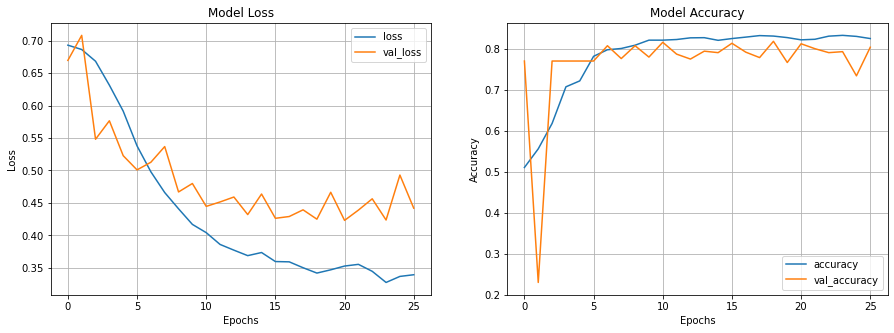

In [12]:
loss_df = pd.DataFrame(history.history)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

loss_df[['loss', 'val_loss']].plot(ax=ax[0], title='Model Loss', grid=True)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')

loss_df[['accuracy', 'val_accuracy']].plot(ax=ax[1], title='Model Accuracy', grid=True)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')

# Save the plot
fig.savefig('Figures/model_performance.png', dpi=300)

# Show the plot in the Jupyter notebook
plt.show()

## Predictions Generation

In [13]:
# Import necessary libraries
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Generate predictions
predictions = model.predict(valid_dataset)
predictions = np.argmax(predictions, axis=1)

# Print predictions and true labels
print("Predictions:", predictions)
y_true = validation_df['labels']
print("True labels:", y_true)

26/26 [==============================] - 47s 2s/step
Predictions: [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0

## Classification Evaluation

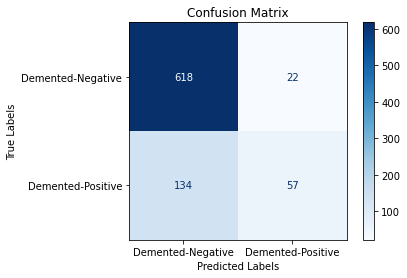

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89       640
           1       0.72      0.30      0.42       191

    accuracy                           0.81       831
   macro avg       0.77      0.63      0.66       831
weighted avg       0.80      0.81      0.78       831



In [14]:
# Create confusion matrix and classification report
cm = confusion_matrix(y_true, predictions)
report = classification_report(y_true, predictions)

# Display confusion matrix with labels
disp = ConfusionMatrixDisplay(cm, display_labels=['Demented-Negative', 'Demented-Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Save the plot
plt.savefig("Figures/confusion_matrix.png", dpi=300, bbox_inches='tight')

# Show the plot in the Jupyter notebook
plt.show()

# Print classification report
print("Classification Report:")
print(report)

## Exporting Model

In [16]:
tf.keras.models.save_model(model, filepath='./AD-model')

INFO:tensorflow:Assets written to: ./AD-model/assets


INFO:tensorflow:Assets written to: ./AD-model/assets


## Exporting Misclassified Images

In [15]:
# Export Misclassified Images
miss_classified = []
for idx, labels in enumerate(zip(y_true, predictions)):
    if labels[0] != labels[1]:
        miss_classified.append(idx)

print(f"Number of Misclassified Images: {len(miss_classified)}")
print(f"Sample Indices of Misclassified Images: {miss_classified[:5]}")

# Create a DataFrame of Misclassified Images
missed_df = validation_df.iloc[miss_classified]
missed_df['pre_labels'] = missed_df['labels'].map({0:1, 1:0})

# Save the DataFrame to a CSV file
missed_df.to_csv('MisClassified_Results.csv', index_label=0)

# Display the DataFrame of Misclassified Images
print("\nDataFrame of Misclassified Images:\n")
print(missed_df)

Number of Misclassified Images: 156
Sample Indices of Misclassified Images: [5, 82, 100, 169, 170]

DataFrame of Misclassified Images:

                                   image_path  labels  pre_labels
5        Dataset/test/NonDemented/31 (59).jpg       0           1
82        Dataset/test/NonDemented/28 (5).jpg       0           1
100      Dataset/test/NonDemented/27 (59).jpg       0           1
169      Dataset/test/NonDemented/27 (64).jpg       0           1
170      Dataset/test/NonDemented/26 (64).jpg       0           1
..                                        ...     ...         ...
824  Dataset/test/ModerateDemented/31 (2).jpg       1           0
826      Dataset/test/ModerateDemented/27.jpg       1           0
827      Dataset/test/ModerateDemented/32.jpg       1           0
828      Dataset/test/ModerateDemented/30.jpg       1           0
829      Dataset/test/ModerateDemented/31.jpg       1           0

[156 rows x 3 columns]


<ipython-input-15-ddd9a2eda7cd>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missed_df['pre_labels'] = missed_df['labels'].map({0:1, 1:0})


## Explainability Analysis

In this part, we demonstrate the use of several XAI (Explainable Artificial Intelligence) techniques for model explainability on our trained CNN model for diagnosing dementia. The XAI techniques used in this script include GradientsInputs, GradCAM, OcclusionSensitivity, and IntegratedGradients. First, we load our pre-trained model and iterates over four different images (from both classes) to generate heatmaps using each of the XAI techniques. The first two columns of the resulting 4x4 grid of heatmaps are representative of the negative group (NonDemented subjects) while the last two columns are representative of the positive group (Demented subjects). 

### Load images

In [129]:
# Create a TensorFlow dataset for explainers (Approach 2: On trained model)
import tensorflow as tf 
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


validation = pd.read_csv('alzheimers-validation-set.csv')
validation.tail()

neg_image_paths = validation['image_path'][:2].to_list()
pos_image_paths = validation['image_path'][-2:].to_list()
explainer_image_paths = neg_image_paths + pos_image_paths
explainer_label = [0] * 2 + [1] * 2

explainer_imgs = []
for img_path in explainer_image_paths:
    image = tf.io.read_file(img_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.cast(image, dtype=tf.float32)
    image = tf.image.resize(image, size=(224,224))
    image = image / 255.0
    explainer_imgs.append(image.numpy())
explainer_imgs = np.array(explainer_imgs)

explainer_label = tf.one_hot(np.array(explainer_label), 2)

print("Number of explainer images:", len(explainer_imgs))
print("Explainer labels:")
print(explainer_label)

Number of explainer images: 4
Explainer labels:
tf.Tensor(
[[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]], shape=(4, 2), dtype=float32)


### Explainers Implementation

<ipython-input-131-66396aa8cf9a>:27: UserWarning: Unsupported model architecture for VanillaGradients. The last two layers of the model should be: a layer which computes class scores with no activation, followed by an activation layer.
  grid = explainer.explain(data, model, class_index=1) # 'NonDemented': 0, 'Demented': 1


8/8 [==============================] - 17s 2s/step


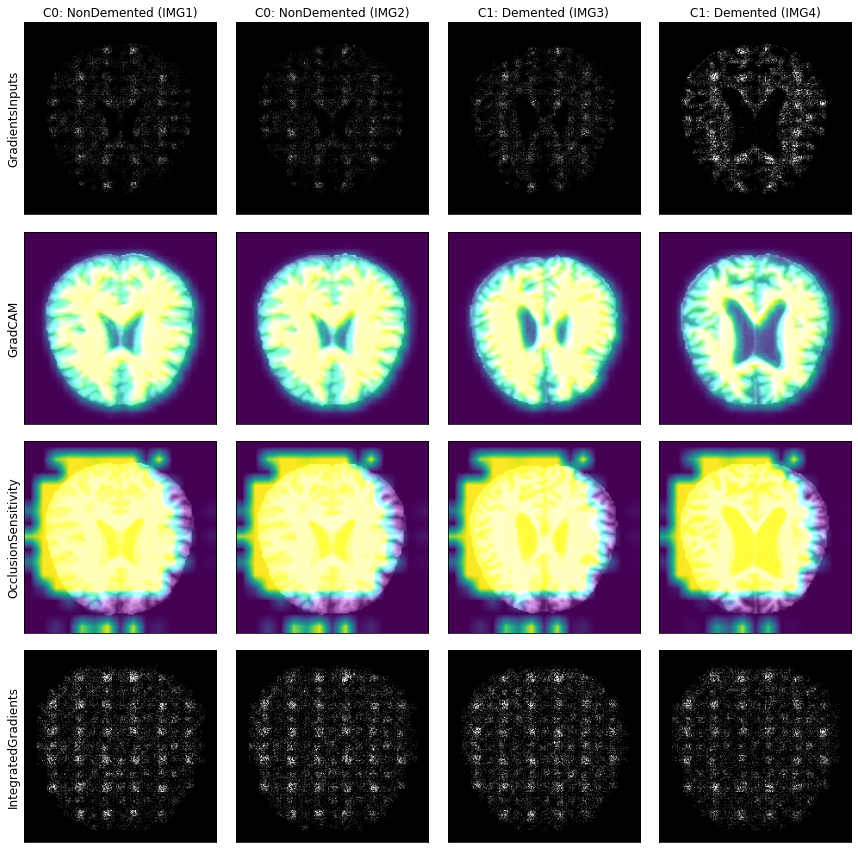

In [131]:
import matplotlib.pyplot as plt
from tf_explain.core.vanilla_gradients import VanillaGradients
from tf_explain.core.gradients_inputs import GradientsInputs
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity
from tf_explain.core.grad_cam import GradCAM
from tf_explain.core.smoothgrad import SmoothGrad
from tf_explain.core.integrated_gradients import IntegratedGradients

# Load Model
model = tf.keras.models.load_model('AD-model/')

# Set up subplots
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))

# Define method names
method_names = ["GradientsInputs", "GradCAM", "OcclusionSensitivity", "IntegratedGradients"]

cols = ['{}'.format(col) for col in ["C0: NonDemented (IMG1)", "C0: NonDemented (IMG2)", "C1: Demented (IMG3)", "C1: Demented (IMG4)"]]
rows = ['{}'.format(row) for row in ["GradientsInputs", "GradCAM", "OcclusionSensitivity", "IntegratedGradients"]]

# Iterate over four images
for i in range(4):
    
    # Compute GradientsInputs visualization
    explainer = GradientsInputs()
    data = ([explainer_imgs[i]], None)
    grid = explainer.explain(data, model, class_index=1) # 'NonDemented': 0, 'Demented': 1
    explainer.save(grid, "heatmaps", f"gradients_inputs_{i}.png")
    gradients_inputs_img = plt.imread("heatmaps/gradients_inputs_{}.png".format(i))
    
    # Compute GradCAM visualization
    explainer = GradCAM()
    data = ([explainer_imgs[i]], None)
    grid = explainer.explain(data, model, class_index=1, layer_name="conv3_block1_1_conv")
    explainer.save(grid, "heatmaps", f"grad_cam_{i}.png")
    grad_cam_img = plt.imread("heatmaps/grad_cam_{}.png".format(i))
    
    # Compute OcclusionSensitivity visualization
    explainer = OcclusionSensitivity()
    data = ([explainer_imgs[i]], None)
    grid = explainer.explain(data, model, class_index=1, patch_size=15)
    explainer.save(grid, "heatmaps", f"occlusion_sensitivity_{i}.png")
    occlusion_sensitivity_img = plt.imread("heatmaps/occlusion_sensitivity_{}.png".format(i))
    
    # Compute IntegratedGradients visualization
    explainer = IntegratedGradients()
    data = ([explainer_imgs[i]], None)
    grid = explainer.explain(data, model, class_index=1, n_steps=15)
    explainer.save(grid, "heatmaps", f"integrated_gradients_{i}.png")
    integrated_gradients_img = plt.imread("heatmaps/integrated_gradients_{}.png".format(i))
    
#     # Compute SmoothGrad visualization
#     explainer = SmoothGrad()
#     data = ([explainer_imgs[i]], None)
#     grid = explainer.explain(data, model, class_index=1, num_samples=20, noise=0.05)
#     explainer.save(grid, "heatmaps", f"smoothgrad_{i}.png")
#     smoothgrad_img = plt.imread("heatmaps/smoothgrad_{}.png".format(i))    
    
#     # Compute VanillaGradients visualization
#     explainer = VanillaGradients()
#     data = ([explainer_imgs[i]], None)
#     grid = explainer.explain(data, model, class_index=1)
#     explainer.save(grid, "heatmaps", f"vanilla_gradients_{i}.png")
#     vanilla_gradients_img = plt.imread("heatmaps/vanilla_gradients_{}.png".format(i))
    
    # Display images on subplots
    axs[0, i].imshow(gradients_inputs_img, cmap='binary_r')
    axs[1, i].imshow(grad_cam_img)
    axs[2, i].imshow(occlusion_sensitivity_img)
    axs[3, i].imshow(integrated_gradients_img, cmap='binary_r')

    
for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, size='large')

# Remove ticks
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
# Save the plot
plt.savefig("Figures/heatmaps.png", dpi=300, bbox_inches='tight')    
    
# Show plot
fig.tight_layout()
plt.show()

### Activations

We could  also visualize the activations of specific layers in the neural network to gain insights into how the model processes the input data. This can be achieved using the `tf_explain` library and its `ExtractActivations` class.

In this example, we define target_layers as `conv2_block1_1_conv`, which is the first convolutional layer in the second residual block of the ResNet50 model. We then call the explain method of the explainer to compute the activations of the target layer for the given input data and model.

1/1 [==============================] - 0s 72ms/step


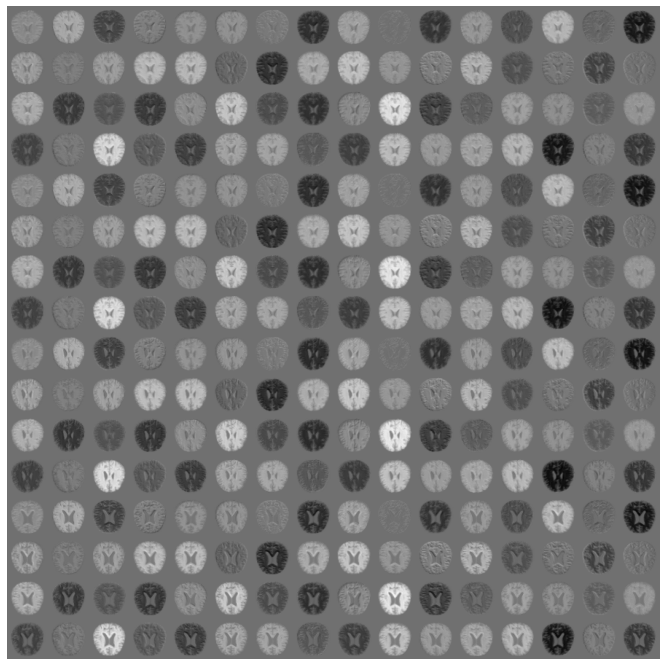

In [145]:
from tf_explain.core.activations import ExtractActivations

target_layers = [
    "conv2_block1_1_conv" # conv1_relu | conv2_block1_1_conv 
]  # Could be either the output of a Conv2D, or an activation

data = ([explainer_imgs], None)

# Start explainer
explainer = ExtractActivations()
# Compute Activations of layer ...
grid = explainer.explain(data, model, target_layers)
explainer.save(grid, "Figures", "activations.png")
activations_img = plt.imread("Figures/activations.png")

# Display the image
plt.figure(figsize=(12, 12))
plt.imshow(activations_img, cmap='gray')
plt.axis('off')
plt.show()